<a href="https://colab.research.google.com/github/JaimeOlivaresNV/BizOpsExperimental/blob/main/Lazada_Shopee_Scrape_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shopee Scrape

we can use Shopee API

In [68]:
# Data manipulation
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Parse Lazada HTML
from bs4 import BeautifulSoup, SoupStrainer
import json
from urllib.request import urlopen

import requests
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Fuzzy String Match
!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz, process


Setup Shopee API and keywords

In [76]:
Shopee_url = 'https://shopee.com.ph'
keyword_search = 'ginza tv 24 inches'
headers = {
 'User-Agent': 'Chrome',
 'Referer': '{}search?keyword={}'.format(Shopee_url, keyword_search)
}
url = 'https://shopee.ph/api/v2/search_items/?by=relevancy&keyword={}&limit=100&newest=0&order=desc&page_type=search'.format(keyword_search)
# Shopee API request
r = requests.get(url, headers = headers).json()
# Shopee scraping script
titles_list = []
prices_list = []
for item in r['items']:
    titles_list.append(item['name'])
    prices_list.append(item['price_min'])

# Save Results as Dataframe
dfS = pd.DataFrame(zip(titles_list, prices_list), columns=['ItemName', 'Price'])
dfS['Platform'] = 'Shopee'
# Remove the ‘PH’ string from Price and change column type to float
dfS['Price'] = dfS['Price'] / 100000

In [77]:
'''
Need to make this part more robust (does product match search? ; remove multiple pack versions)
'''
# Remove false entries i.e. those which are not actually Nescafe Gold Refill 170g
# dfS = dfS[dfS['ItemName'].str.contains('170g') == True] # Poor search function Shopee!!!
# Some of the items are actually x2 packs. Remove them too
# dfS = dfS[dfS['ItemName'].str.contains('[2x\s]{3}|twin',flags=re.IGNORECASE, regex=True) == False]

dfS['fuzzyscore_TSoR'] = dfS.apply(lambda x: fuzz.partial_token_sort_ratio(keyword_search,x['ItemName']), axis=1)
dfS['fuzzyscore_WR'] = dfS.apply(lambda x: fuzz.WRatio(keyword_search,x['ItemName']), axis=1)
dfS['fuzzyscore_mean'] = dfS[['fuzzyscore_TSoR', 'fuzzyscore_WR']].mean(axis=1)
dfS.sort_values(by=['fuzzyscore_mean'], ascending=False, inplace=True)
dfS

,ItemName,Price,Platform,fuzzyscore_TSoR,fuzzyscore_WR,fuzzyscore_mean
71,TV GINZA LED TV 22INCH 24INCH Model (screen si...,2499.0,Shopee,78,86,82.0
27,(Free bracket)GINZA 24 inch led TV flatscreen ...,5527.0,Shopee,72,86,79.0
44,❏❐❀GINZA 24 Inch Flat Screen TV Sale LED,9473.0,Shopee,72,86,79.0
24,❃❖GINZA 24 Inch Flat Screen TV Sale LED TV,4566.0,Shopee,72,86,79.0
58,GINZA 24 Inch Flat Screen TV Sale LED TV JKWo,29385.0,Shopee,72,86,79.0
...,...,...,...,...,...,...
33,5Pcs 3v 6v 32-65'' LED TV Backlight Replacemen...,35.0,Shopee,39,86,62.5
57,True Vision Adjustable CPU Bracket for Under D...,1701.0,Shopee,33,86,59.5
65,FTStar Universal TV Wall Mount Bracket For 14-...,67.0,Shopee,33,86,59.5
97,"TV 26""-63”LED/LCD TV Wall Mount/Bracket COD",95.0,Shopee,33,86,59.5


In [78]:
'''
Stats to collate later:
mean, std, Q1 (25%), Q3 (75%)
'''
dfS.Price.describe()
# dfS.Price.describe()[['mean','std','25%','75%']]

count      100.000000
mean      5269.850000
std       5421.543348
min         35.000000
25%       2049.000000
50%       3360.000000
75%       5909.250000
max      29385.000000
Name: Price, dtype: float64

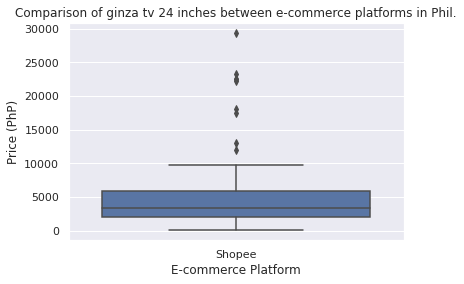

In [79]:
'''
Investigative Plot for Price Range (Single Product)
'''

# Plot the chart
sns.set()
_ = sns.boxplot(x='Platform', y='Price', data=dfS)
_ = plt.title('Comparison of {} between e-commerce platforms in Phil.'.format(keyword_search))
_ = plt.ylabel('Price (PhP)')
_ = plt.xlabel('E-commerce Platform')
# Show the plot
plt.show()

# Lazada Scrape

I’ve been told frequently that between the two major e-commerce platforms in Malaysia (Lazada and Shopee), one is generally cheaper and attracts bargain hunters while the other generally caters to the less price sensitive.
Well, I’ve decided to find out myself… in a battle of the e-commerce platforms!
To do so I’ll be writing a Python script using Selenium and the Chrome web driver to automate the scraping process and build our dataset. Here, we will be scraping for the following:
Product name; and
Product price
I will then conduct some basic data analysis using Pandas on the dataset we have scraped. As part of this exercise, some data cleaning will also be required and at the end of the exercise I will be presenting the price comparison on a simple visual chart using Matplotlib and Seaborn.
Between the two platforms, I’ve found the Shopee website more difficult to scrape for data for a couple of reasons: (1) it contains annoying popup boxes which appear when entering the page; and (2) the website class elements are not as well defined (some elements have multiple classes).
For this reason we will start with scraping the Lazada website first, and then we will deal with Shopee in Part 2!
First, we import the necessary packages:

In [74]:
Lazada_url = 'https://www.lazada.com.ph'

cookies = {
    "user": "en"
    }
req_headers = {
        "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36",
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "x-requested-with": "XMLHttpRequest",
    }
proxies = {"https": "http://000.0.0.0:0000"}

# response_data = requests.get(product_url, headers=req_headers, cookies=cookies, proxies=proxies, verify=False)

In [75]:
with open('outputlazada.txt','w') as w:
  search = keyword_search
  with requests.Session() as c:
    url = 'https://www.lazada.com.ph/catalog/?q='+keyword_search
    c.get(url)
    search_data = dict(q = keyword_search)
    page = c.post(url, data = search_data, headers=req_headers, cookies=cookies, proxies=proxies, verify=False)
    page = page.content
    new_url = page.encode('utf-8')

ProxyError: ignored

In [71]:
page

b'<h1>404 Not Found</h1>'

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="a2o4l" name="data-spm"/>
<meta content="perc5odk-tesq6o32" name="wpk-bid"/>
<meta content="gsearch-pc" name="wpk-cid"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width" name="viewport"/>
<link href="https://s.alicdn.com" rel="dns-prefetch"/>
<link href="https://laz-g-cdn.alicdn.com" rel="preconnect"/>
<link href="https://laz-img-cdn.alicdn.com" rel="preconnect"/>
<link href="https://g.alicdn.com" rel="preconnect"/>
<link href="https://member.lazada.sg" rel="preconnect"/>
<link href="https://cart.lazada.sg" rel="preconnect"/>
<link href="https://retcode-sg-lazada.arms.aliyuncs.com" rel="preconnect"/>
<link href="https://as.alipayobjects.com" rel="dns-prefetch"/>
<link href="https://d.alicdn.com" rel="dns-prefetch"/>
<link href="https://assets.alicdn.com" rel="dns-prefetch"/>
<link as="script" href="//laz-g-cdn.alicdn.com/lzd/assets/1.1.33/??babel-polyfill/6.26.0/polyfi
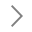

In [69]:
def get_data(pageNo):  
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    r = requests.get('https://www.lazada.com.ph/catalog/?q='+keyword_search, headers=headers)
    content = r.content
    soup = BeautifulSoup(content)
    print(soup)

get_data(2)

In [ ]:
def get_data(pageNo):  
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    r = requests.get('https://www.lazada.com.ph/catalog/?q='+keyword_search, headers=headers)
    content = r.content
    soup = BeautifulSoup(content)
    #print(soup)

    alls = []
    for d in soup.findAll('div', attrs={'class':'a-section a-spacing-none aok-relative'}):
        #print(d)
        name = d.find('span', attrs={'class':'zg-text-center-align'})
        n = name.find_all('img', alt=True)
        #print(n[0]['alt'])
        author = d.find('a', attrs={'class':'a-size-small a-link-child'})
        rating = d.find('span', attrs={'class':'a-icon-alt'})
        users_rated = d.find('a', attrs={'class':'a-size-small a-link-normal'})
        price = d.find('span', attrs={'class':'p13n-sc-price'})

        all1=[]

        if name is not None:
            #print(n[0]['alt'])
            all1.append(n[0]['alt'])
        else:
            all1.append("unknown-product")

        if author is not None:
            #print(author.text)
            all1.append(author.text)
        elif author is None:
            author = d.find('span', attrs={'class':'a-size-small a-color-base'})
            if author is not None:
                all1.append(author.text)
            else:    
                all1.append('0')

        if rating is not None:
            #print(rating.text)
            all1.append(rating.text)
        else:
            all1.append('-1')

        if users_rated is not None:
            #print(price.text)
            all1.append(users_rated.text)
        else:
            all1.append('0')     

        if price is not None:
            #print(price.text)
            all1.append(price.text)
        else:
            all1.append('0')
        alls.append(all1)    
    return alls

In [ ]:
browser.maximize_window() # For maximizing window
browser.implicitly_wait(20) # gives an implicit wait for 20 seconds
search_bar = browser.find_element_by_id('q')
# search_bar.send_keys(search_item)
# search_bar.submit()

search_bar.send_keys(search_item).submit()

NoSuchElementException: ignored

Okay so that’s the easy part. Now comes the part which can be challenging, and even more so if you’re trying to scrape from the Shopee website!

To figure out how you would scrape the item names and prices from the Lazada, imagine how you would do it manually. What you might do is this:

Copy each of the item name and its price onto a spreadsheet table;
Go to the next page and repeat the first step until you’ve reached the last page

That’s exactly how we would do it as well in this automation process! To do so, we will need to find the elements containing the item names and prices, and also the next page button.

Using the same Chrome inspect tool, we can see that the product titles and prices have the class names ‘c16H9d’ and ‘c13VH6’ respectively. It’s important to check that the same class names apply to all the items on the page, in order to ensure successful scraping of all the items on the page.

In [ ]:
item_titles = browser.find_elements_by_class_name('c16H9d')
item_prices = browser.find_elements_by_class_name('c13VH6')

In [ ]:
'''
Next, we unpack the item_titles and item_prices variables onto lists:
'''

# Initialize empty lists
titles_list = []
prices_list = []
# Loop over the item_titles and item_prices
for title in item_titles:
  titles_list.append(title.text)
for price in item_prices:
  prices_list.append(prices.text)

**Sample Output**

[‘NESCAFE GOLD Refill 170g x2 packs’, ‘NESCAFE GOLD Original Refill Pack 170g’, ‘Nescafe Gold Refill Pack 170g’, ‘NESCAFE GOLD Refill 170g’, ‘NESCAFE GOLD REFILL 170g’, ‘NESCAFE GOLD Refill 170g’, ‘Nescafe Gold Refill 170g’, ‘[EXPIRY 09/2020] NESCAFE Gold Refill Pack 170g x 2 — NEW PACKAGING!’, ‘NESCAFE GOLD Refill 170g’] 
[‘RM55.00’, ‘RM22.50’, ‘RM26.76’, ‘RM25.99’, ‘RM21.90’, ‘RM27.50’, ‘RM21.88’, ‘RM27.00’, ‘RM26.76’, ‘RM23.00’, ‘RM46.50’, ‘RM57.30’, ‘RM28.88’]



Once we’re done scraping from this page, let’s move on to the next page. 

Again here we will use the find_element method, but this time using XPath. 

Using XPath is necessary here because the next page button has two classes, and the find_element_by_class_name method only finds elements from a single class.

Also important to note here, we need to tell the browser what to do if the next page button is disabled (meaning if the results are shown only in one page or if we’ve reached the end page of the results).

In [ ]:
'''
Here we’ve instructed the browser to close if the button is disabled. If it’s not disabled, it will proceed to the next page and we will then need to repeat the scraping process.
'''
try:
  browser.find_element_by_xpath(‘//*[@class=”ant-pagination-next” and not(@aria-disabled)]’).click()
except NoSuchElementException: 
  browser.quit()



We now begin to analyze the data we’ve scraped using Pandas. We start by converting the two lists into a dataframe:

In [ ]:
dfL = pd.DataFrame(zip(titles_list, prices_list), columns=[‘ItemName’, ‘Price’])

While the dataset looks good, it isn’t very clean. If you print the information of the dataframe using the Pandas .info() method it shows that the Price column type is a string object, rather than a float type. This is expected as each entry in the Price column contains the currency symbol ‘RM’ (Malaysian Ringgit). However, if the Price column is not an integer or float type column, we will not be able to extract any statistical features on it.
We will therefore need to remove the currency symbol and convert the entire column into a float type with the following method:

In [ ]:
dfL[‘Price’] = dfL[‘Price’].str.replace(‘RM’, ‘’).astype(float)

Awesome! However, there’s still some more cleaning to be done. You might have noticed an anomaly in the dataset. One of the items is actually a twin pack, which we will need to remove from our dataset.
Data cleaning is essential for any sort of data analysis and here we will weed out entries that we don’t want with the following:

In [ ]:
# This removes any entry with 'x2' in its title
dfL = dfL[dfL[‘ItemName’].str.contains(‘x2’) == False]

Although unnecessary here, you may also want to ensure that the items that appear are the items we specifically searched for. Sometimes other related products may appear in your search list, especially if your search term isn’t specific enough.
For example, if we had searched ‘nescafe gold refill’ instead of ‘nescafe gold refill 170g’, 117 items would have appeared instead of just the 9 we scraped earlier. The additional items aren’t the refill packs we were searching for, but rather capsule filter cups instead. Nonetheless, it doesn’t hurt to filter your dataset again with your search term:

In [ ]:
dfL = dfL[dfL[‘ItemName’].str.contains(‘170g’) == True]

SyntaxError: ignored

As a final touch, we will also create a column ‘Platform’ and assign ‘Lazada’ to each of the entries here. This is done so that we can later group the entries by platforms (Lazada and Shopee) when we later conduct the price comparison between the two platforms.

In [ ]:
dfL[‘Platform’] = ‘Lazada’

Now it’s time to visualize our data, with Matplotlib and Seaborn. We will be using a box plot, as it uniquely represents all the following key statistical features (also known as the five number summary) in one chart:
Lowest price
Highest price
Median price
25th and 75th percentile price

In [ ]:
# Plot the chart
sns.set()
_ = sns.boxplot(x=’Platform’, y=’Price’, data=dfL)
_ = plt.title(‘Comparison of Nescafe Gold Refill 170g prices between e-commerce platforms in Malaysia’)
_ = plt.ylabel(‘Price (RM)’)
_ = plt.xlabel(‘E-commerce Platform’)
# Show the plot
plt.show()

# Combine Datasets

Now let's combine the Lazada and Shopee datasets! We do this by using the pandas concatenation method:


In [ ]:
# Add column [‘Platform’] for each platforms
dfL[‘Platform’] = ‘Lazada’
dfS[‘Platform’] = ‘Shopee’
# Concatenate the Dataframes
df = pd.concat([dfL,dfS])

In [ ]:
print(df.groupby([‘Platform’]).describe())

In [ ]:
sns.set()
_ = sns.boxplot(x=’Platform’, y=’Price’, data=df)
_ = plt.title(‘Comparison of Nescafe Gold Refill 170g prices between e-commerce platforms in Malaysia’)
_ = plt.ylabel(‘Price (RM)’)
_ = plt.xlabel(‘E-commerce Platform’)
# Show the plot
plt.show()

In [ ]:
import time
# Add Timestamp
dfL[‘datetime’] = pd.Timestamp.today()
dfS[‘datetime’] = pd.Timestamp.today()
# Save dataframe to a csv file
timestamp = str(pd.Timestamp.today()).replace(":", ".")
df.to_csv('PriceComparison_{}.csv'.format(timestamp))